/home/raul/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


     id   age cabin embarked     fare                          name  parch  \
0   306  54.0   D26        S  77.2875   White, Mr. Percival Wayland      1   
1   927   NaN   NaN        C  14.4542            Khalil, Mr. Betros      0   
2   642  13.0   NaN        S  31.3875  Asplund, Master. Filip Oscar      2   
3  1294  28.5   NaN        S  16.1000          Williams, Mr. Leslie      0   
4  1015  55.5   NaN        S   8.0500              Meo, Mr. Alfonzo      0   

   pclass   sex  sibsp  survived      ticket  
0       1  male      0         0       35281  
1       3  male      1         0        2660  
2       3  male      4         0      347077  
3       3  male      0         0       54636  
4       3  male      0         0  A.5. 11206  
Index(['id', 'age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'pclass',
       'sex', 'sibsp', 'survived', 'ticket'],
      dtype='object')
687
229
687
229
Index(['age', 'embarked', 'fare', 'name', 'parch', 'pclass', 'sex', 'sibsp'], dtype='obje

The accuracy score is 0.7248908296943232
Trying the set of paras {'bootstrap': False, 'max_depth': 17, 'min_samples_leaf': 53, 'min_samples_split': 91, 'n_estimators': 1038}
The accuracy score is 0.7336244541484717
Trying the set of paras {'bootstrap': False, 'max_depth': 11, 'min_samples_leaf': 59, 'min_samples_split': 44, 'n_estimators': 762}
The accuracy score is 0.7336244541484717
Trying the set of paras {'bootstrap': True, 'max_depth': 29, 'min_samples_leaf': 30, 'min_samples_split': 18, 'n_estimators': 1927}
The accuracy score is 0.7292576419213974
Trying the set of paras {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 36, 'min_samples_split': 44, 'n_estimators': 200}
The accuracy score is 0.74235807860262
Trying the set of paras {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 56, 'n_estimators': 933}
The accuracy score is 0.7467248908296943
Trying the set of paras {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples

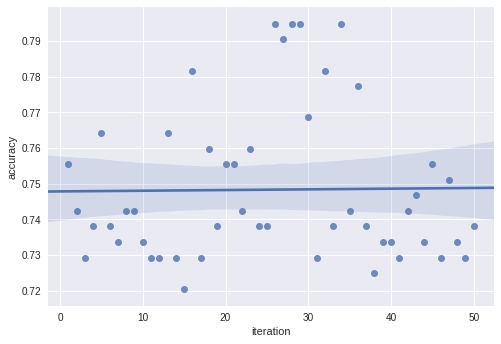

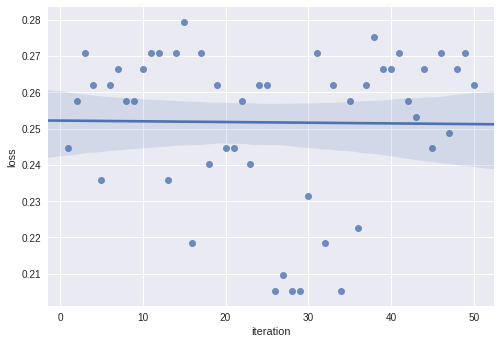

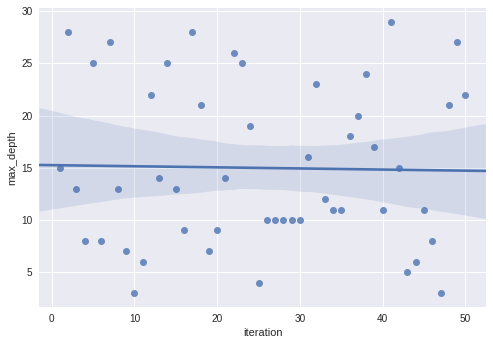

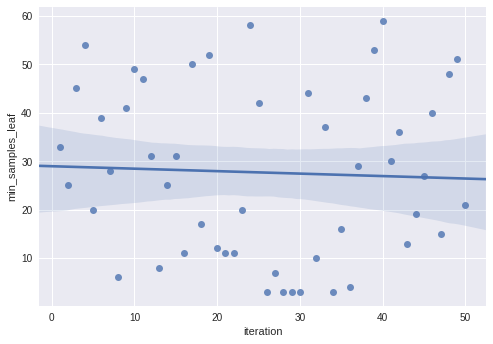

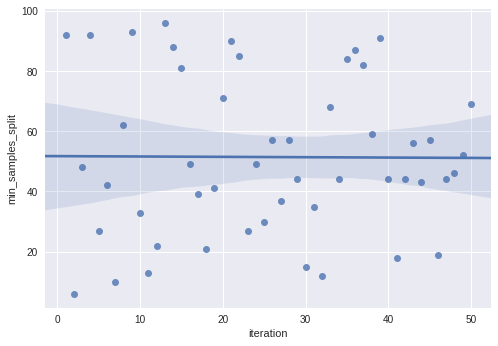

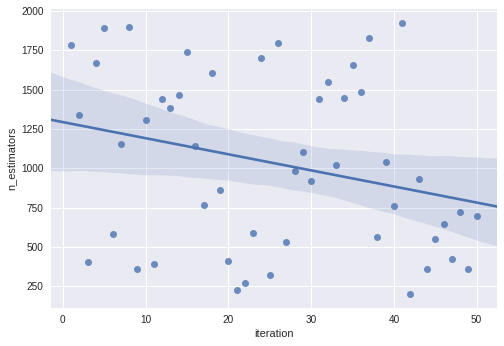

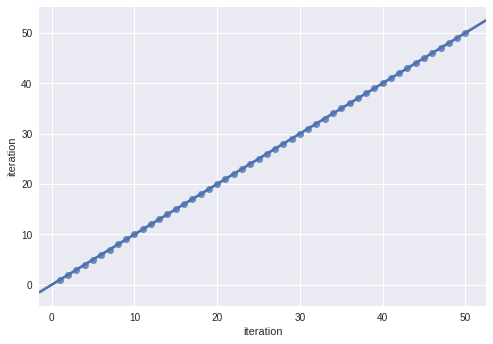

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
import category_encoders as ce
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time



#TODO: Train Randon forest classifiers

#read the data
data_path = 'data/train.csv'
TrainDF = pd.read_csv(data_path)
print(TrainDF.head())

print(TrainDF.columns)
#potenfial config columns
#ignoring cabin
feature_columns = ['age', 'embarked', 'fare', 'name', 'parch', 'pclass',
       'sex', 'sibsp']
target_column = ['survived']

#split train_test
X_train, X_test, y_train, y_test = train_test_split(TrainDF[feature_columns], TrainDF[target_column].values.ravel())


print(len(X_train))

print(len(X_test))

print(len(y_train))

print(len(y_test))


#X_train = TrainDF[feature_columns]

#convert to np array
#y_train = TrainDF[target_column].values.ravel()

#labelendoding
categorical_columns = ['embarked', 'name', 'parch', 'pclass',
       'sex']
# Labels are the values we want to predict
OEncoder = ce.ordinal.OrdinalEncoder(cols=categorical_columns)
X_train = OEncoder.fit_transform(X_train)
X_train = X_train.fillna(X_train.mean())

X_test = OEncoder.transform(X_test)
X_test = X_test.fillna(X_train.mean())


#define classifier
clf = RandomForestClassifier()
clf.fit(X = X_train,y = y_train)



print(X_train.columns)
importances = clf.feature_importances_
print(importances)

y_pred = clf.predict(X_test)

print(len(y_pred))

print(len(y_test))
#accuracy
print(metrics.accuracy_score(y_test,y_pred))

print(metrics.roc_auc_score(y_test,y_pred))
#TODO: perform cross validation

print(cross_val_score(clf, X_train, y_train, cv=7))

#TODO: Explain what all the hyperparameters do


#TODO: Use hyperparamenter tuning
from hyperopt import hp
from hyperopt import STATUS_OK

initial_params = clf.get_params()
print(initial_params)

clf.set_params(**initial_params)

#print(type(str(initial_params)))
print(cross_val_score(clf, X_train, y_train, cv=7))


def the_objective(params, X_train_s = X_train,y_train_s = y_train,X_test = X_test, y_test = y_test):
       '''
       :param params: Random Forest Params
       :param cv: Cross Validation folds
       :return:
       '''

       clf_ =  RandomForestClassifier()
       clf_.set_params(**params)
       print("Trying the set of paras {}".format(params))
       clf_.fit(X_train_s,y_train_s)
       y_pred = clf_.predict(X_test)
       accuracy_score =  metrics.accuracy_score(y_test, y_pred)
       print("The accuracy score is {}".format(accuracy_score))

       accuracy_inverse = 1 - accuracy_score
       #best = cv_results.mean()
       #print(cv_results)
       return {'loss': accuracy_inverse, 'params': params, 'status': STATUS_OK, 'accuracy': accuracy_score}

#define space
'''
Using this set of hyperparams
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
Taking the Bayesian Strategy to find the best combination
'''

import numpy as np

grid_space = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


bayes_space = {'bootstrap': hp.choice('bootstrap',[True, False]),
 'max_depth': hp.choice('max_depth', np.arange(3,30, dtype= int)),
 'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(3,60, dtype= int)),
 'min_samples_split': hp.choice('min_samples_split', np.arange(3,100, dtype= int)),
 'n_estimators': hp.choice('n_estimators', np.arange(200,2000, dtype= int))
               }


#testing space
from hyperopt.pyll.stochastic import sample
print('Testing Space')
print(sample(bayes_space))

#run tunning

from hyperopt import Trials, tpe, fmin


bayes_trials = Trials()

best = fmin(fn = the_objective, space = bayes_space, algo = tpe.suggest, max_evals = 50, trials= bayes_trials)

print(best)

#print
#unnesting the parameters to columns
#Getting all results
df_best = pd.DataFrame(bayes_trials.results)

#unnesting the params dictionary
df_best = pd.concat([df_best, df_best.params.apply(pd.Series)], axis = 1, sort = False)
#dropping the dictionary column
df_best = df_best.drop(['params'], axis = 1)
print(df_best.head())

df_best['iteration'] = df_best.index + 1

print(df_best.columns)

import matplotlib.pyplot as plt
import seaborn as sns

print_list = ['accuracy', 'loss', 'max_depth',
       'min_samples_leaf', 'min_samples_split', 'n_estimators', 'iteration']

fig, ax = plt.subplots()

for i,item in enumerate(print_list):
       sns.regplot('iteration', item, data = df_best)
       plt.show()

#train model with best hyperparameters

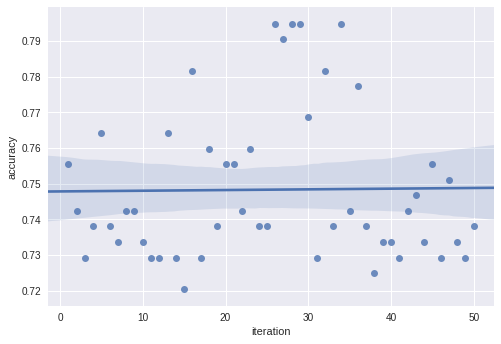

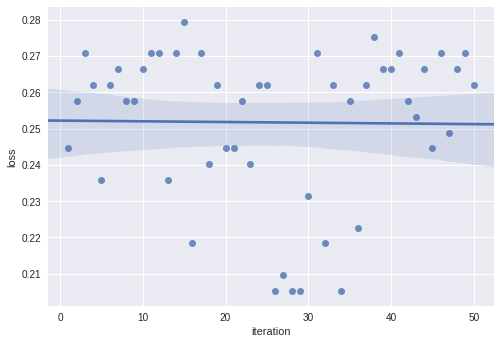

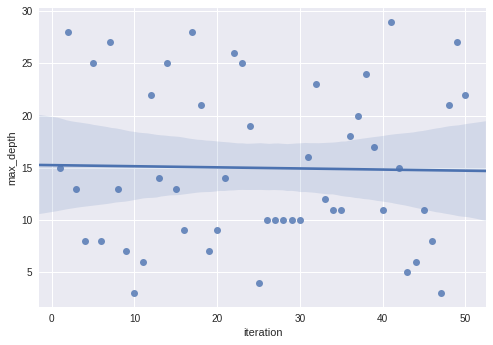

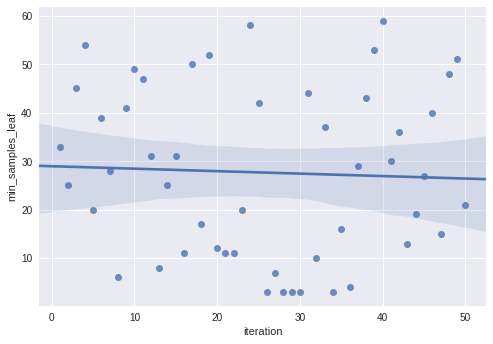

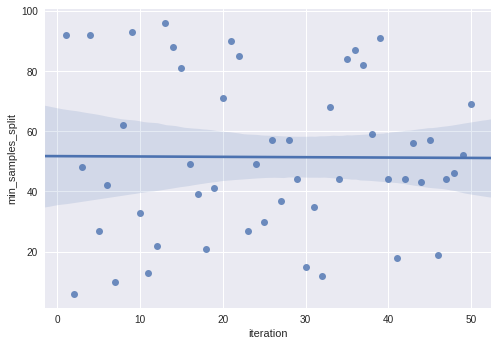

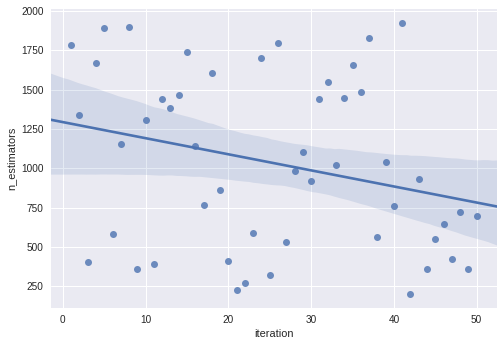

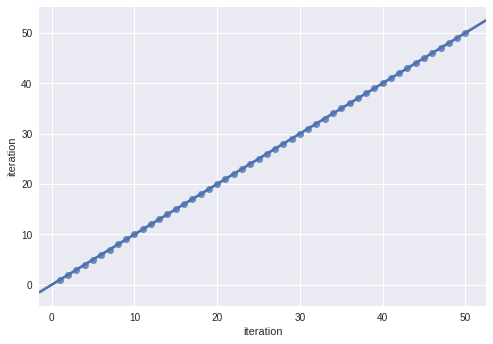

In [3]:
fig, ax = plt.subplots()

for i,item in enumerate(print_list):
       sns.regplot('iteration', item, data = df_best)
       plt.show()